In [1]:
from os.path import join, abspath, expanduser
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import rioxarray as rxa
import contextily as ctx
from tqdm import tqdm
import seaborn as sns
from uavsar_pytools.snow_depth_inversion import depth_from_phase

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = expanduser('~/scratch/data/uavsar/snowpits')
pits_dir = join(data_dir, 'pits')
swe = pd.read_csv(join(data_dir, 'SNEX20_TS_SP_Summary_SWE_v01.csv'), parse_dates = ['Date/Local Standard Time'], index_col= 'PitID')

env = pd.read_csv(join(data_dir, 'SNEX20_TS_SP_Summary_Environment_v01.csv'), parse_dates = ['Date/Local Standard Time'], index_col= 'PitID')

pit_sum = pd.concat([swe, env], axis = 1).reindex(swe.index)
pit_sum = pit_sum.loc[:,~pit_sum.columns.duplicated()]
pit_sum = pit_sum.rename(columns = {'Date/Local Standard Time':'date'})
pit_sum = gpd.GeoDataFrame(pit_sum, geometry=gpd.points_from_xy(pit_sum['Longitude (deg)'], pit_sum['Latitude (deg)']), crs = 4326)

In [4]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        dic['image_data'] = image_fp
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-2, 0, 2]]
                df_range = pit_sum[(pit_sum.date.dt.date > date_range[0]) & (pit_sum.date.dt.date < date_range[-1])]

                if len(df_range) > 0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    points_within = points_within.drop(['index_right'], axis=1)
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    dic[f't{i+1}_pits'] = points_within
                else:
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])], ignore_index=True)

In [15]:
res_dir = '/bsuhome/zacharykeskinen/uavsar/results/snow_pits'
with open(join(res_dir, 'uavsar_pits.pkl'), 'rb') as f:
    res = pickle.load(f)

In [20]:
quick = res.drop(['image_data','t1_pits','t2_pits'], axis = 1)
quick.loc[np.isnan(quick.merged_pits_num), 'merged_pits_num']= 0
quick

,loc,t1,t1_pit_num,t2,t2_pit_num,merged_pits_num
0,"Eldorado National Forest, CA",2020-02-26 23:30:49+00:00,0,2020-03-11 16:05:26+00:00,0,0.0
1,"Eldorado National Forest, CA",2020-01-31 19:30:11+00:00,1,2020-02-12 22:49:46+00:00,0,0.0
2,"Eldorado National Forest, CA",2020-02-19 22:42:09+00:00,0,2020-02-26 23:30:36+00:00,0,0.0
3,"Eldorado National Forest, CA",2020-02-12 22:49:45+00:00,0,2020-02-19 22:42:21+00:00,0,0.0
4,"Donner Memorial State Park, CA",2020-01-31 19:56:40+00:00,0,2020-02-19 23:07:38+00:00,3,0.0
5,"Donner Memorial State Park, CA",2019-12-20 18:29:54+00:00,2,2020-01-31 19:56:39+00:00,0,0.0
6,"Donner Memorial State Park, CA",2020-02-26 23:56:53+00:00,3,2020-03-11 19:34:26+00:00,3,3.0
7,"Donner Memorial State Park, CA",2020-02-19 23:07:38+00:00,3,2020-02-26 23:56:53+00:00,3,3.0
8,"Rocky Mountains NP, CO",2020-02-12 17:27:06+00:00,2,2020-02-19 18:01:09+00:00,2,2.0
9,"Rocky Mountains NP, CO",2020-02-12 18:10:13+00:00,2,2020-02-19 18:42:54+00:00,2,2.0


In [18]:
site_cols = ['index_t2','Location_t1', 'Site_t1', 'date_t1', 'date_t2','UTM Zone_t1', 'Latitude (deg)_t1', 'Longitude (deg)_t1', 'Density Mean (kg/m^3)_t1', 'Density Mean (kg/m^3)_t2', 'SWE (mm)_t1', 'Snow Depth (cm)_t1', 'SWE (mm)_t2', 'Snow Depth (cm)_t2', 'Ground Condition_t1', 'Ground Condition_t2', 'Height of Ground Vegetation (cm)_t1', 'Ground Roughness_t1', 'Canopy_t2', 'sd_diff', 'swe_diff']

site_res = pd.DataFrame()
for i, r in res.iterrows():
    if not r.t1_pits.empty and not r.t2_pits.empty:
        epsg = 26900 + int(r.t1_pits.iloc[0]['UTM Zone'].replace('N',''))
        merged = gpd.sjoin_nearest(r.t1_pits.to_crs(epsg), r.t2_pits.to_crs(epsg), max_distance = 50, lsuffix='t1', rsuffix='t2')
        merged['sd_diff'] = merged['Snow Depth (cm)_t2'] - merged['Snow Depth (cm)_t1']
        merged['swe_diff'] = merged['SWE (mm)_t2'] - merged['SWE (mm)_t1']
        res.loc[i, 'merged_pits_num'] = len(merged)
        for label in ['fp','inc','cor','hgt']:
                img = rxa.open_rasterio(r.image_data[label])
                img = img.rio.reproject(dst_crs = epsg)
                for i_site, r_site in merged.iterrows():
                    site_name = r_site.Location_t1 + '-' + r_site.Site_t1 + '-' + str(r_site.date_t1.date()) + '-' + str(r_site.date_t2.date())
                    if label == 'fp':
                        label = 'unw'
                    site_res.loc[site_name, label] = img.sel(x = r_site.geometry.x, y = r_site.geometry.y, method = 'nearest', tolerance = 50).values[0]
                    site_res.loc[site_name, 'index_t1'] = i_site
                    for col in site_cols:
                        site_res.loc[site_name, col] = r_site[col]
                    # site_res.loc[site_name, f'swe_diff'] = r_site.swe_diff
site_res = site_res.apply(pd.to_numeric, errors='ignore')
num_cols = site_res.columns[site_res.dtypes == float]
num_cols = num_cols.drop(['Latitude (deg)_t1', 'Longitude (deg)_t1'])
cat_cols = ['Ground Condition_t1', 'Ground Condition_t2', 'Height of Ground Vegetation (cm)_t1', 'Ground Roughness_t1', 'Canopy_t2']
site_res[cat_cols] = site_res[cat_cols].apply(lambda x: x.astype('category', errors = 'ignore'))

res_dir = '/bsuhome/zacharykeskinen/uavsar/results/snow_pits'
with open(join(res_dir, 'overlapping_pits.pkl'), 'wb') as f:
    pickle.dump(site_res, f)

res_dir = '/bsuhome/zacharykeskinen/uavsar/results/snow_pits'
with open(join(res_dir, 'uavsar_pits.pkl'), 'wb') as f:
    pickle.dump(res, f)

In [23]:
res_dir = '/bsuhome/zacharykeskinen/uavsar/results/snow_pits'
with open(join(res_dir, 'overlapping_pits.pkl'), 'rb') as f:
    site_res = pickle.load(f)
num_cols = site_res.columns[site_res.dtypes == float]
num_cols = num_cols.drop(['Latitude (deg)_t1', 'Longitude (deg)_t1'])
cat_cols = ['Ground Condition_t1', 'Ground Condition_t2', 'Height of Ground Vegetation (cm)_t1', 'Ground Roughness_t1', 'Canopy_t2']

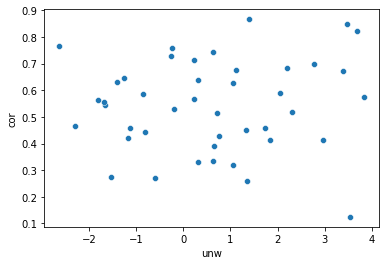

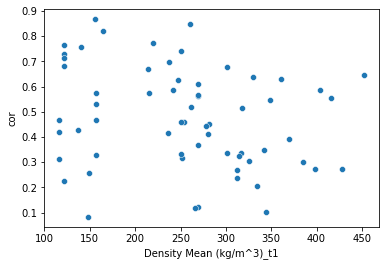

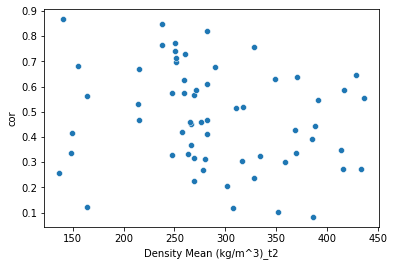

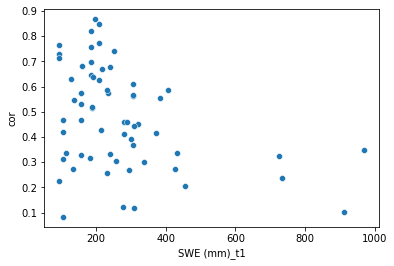

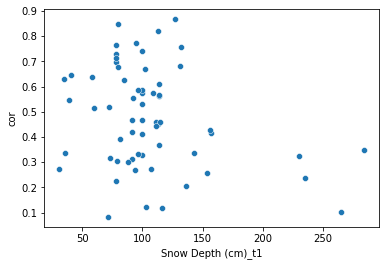

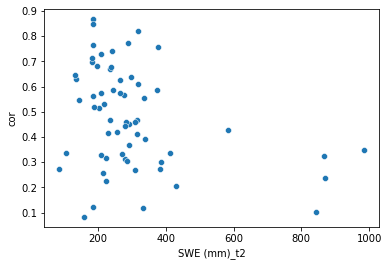

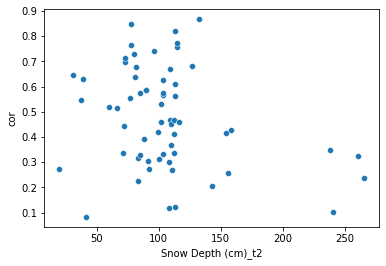

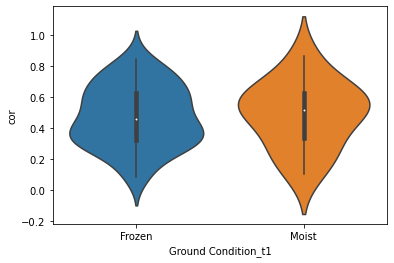

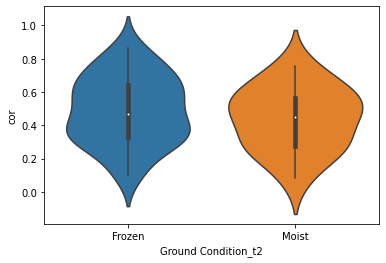

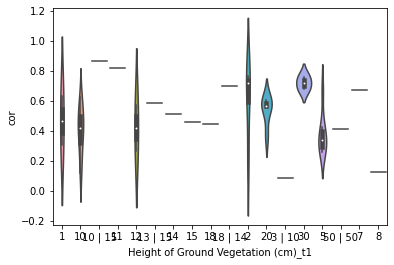

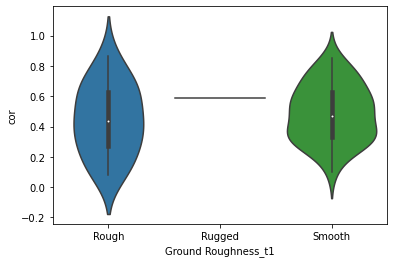

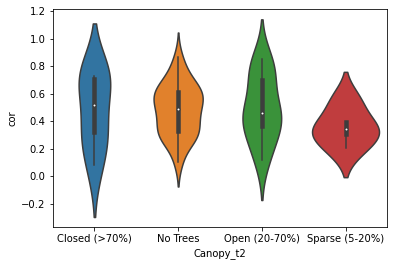

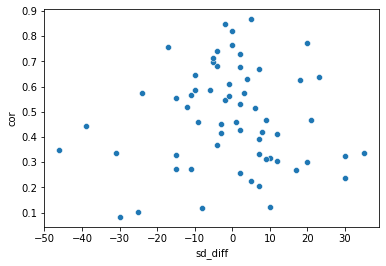

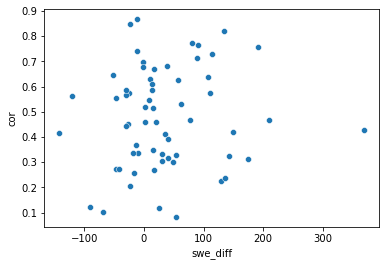

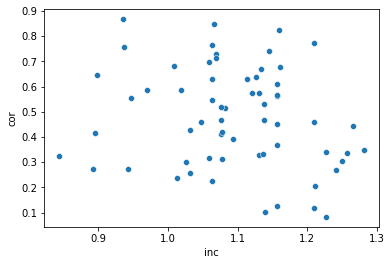

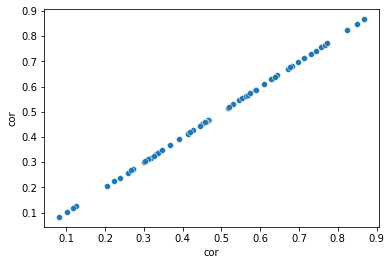

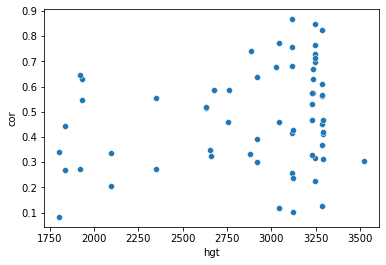

In [24]:
for col in site_res.columns:
    if col in num_cols:
        sns.scatterplot(x = col, y = 'cor', data = site_res)
        plt.show()
    if col in cat_cols:
        sns.violinplot(x = col, y = 'cor', data = site_res)
        plt.show()
    else:
        pass

In [ ]:
for cat_col in cat_cols:
    for num_col in num_cols:
        sns.violinplot(x = cat_col, y = num_col, data = site_res)
        plt.show()